In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/iss/IRS/PM')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import csv, sqlite3,re

In [74]:
conn= sqlite3.connect("LaptopDB.db")
data = pd.read_csv('laptop_data.csv')
data.to_sql('LAPTOPS', conn, if_exists='replace', index=False)

In [75]:
data = pd.read_csv('benchmark.csv')
data.to_sql('BENCHMARK', conn, if_exists='replace', index=False)

In [76]:
data = pd.read_csv('laptop_data.csv')
cluster_data = data.loc[:,('uuid','price','processor','memory','hard_drive','graphics')]
cluster_data.head()

,uuid,price,processor,memory,hard_drive,graphics
0,ee58b3e8-1443-11eb-9321-0242ac1c0002,$699.00,Intel Core i3-1005G1,4,1TB_HDD,Intel UHD Graphics
1,ee638a70-1443-11eb-9321-0242ac1c0002,"$1,099.00",Intel Core i3-1115G4,8,256GB_SSD,Intel UHD Graphics
2,ee6d5fdc-1443-11eb-9321-0242ac1c0002,"$1,148.99",Intel Core i5-1135G7,8,256GB_SSD,Intel Iris Xe Graphics
3,ee785c5c-1443-11eb-9321-0242ac1c0002,"$1,198.99",Intel Core i7-1065G7,8,1TB_HDD,NVIDIA GeForce MX230
4,ee8291a4-1443-11eb-9321-0242ac1c0002,"$1,248.99",Intel Core i5-1135G7,8,512GB_SSD,Intel Iris Xe Graphics


In [77]:
## grade memory
cluster_data.loc[cluster_data.memory<4,'memory']=0
cluster_data.loc[cluster_data.memory==4,'memory']=1
cluster_data.loc[cluster_data.memory==8,'memory']=1
cluster_data.loc[cluster_data.memory>8,'memory']=2

cluster_data.head()

,uuid,price,processor,memory,hard_drive,graphics
0,ee58b3e8-1443-11eb-9321-0242ac1c0002,$699.00,Intel Core i3-1005G1,1,1TB_HDD,Intel UHD Graphics
1,ee638a70-1443-11eb-9321-0242ac1c0002,"$1,099.00",Intel Core i3-1115G4,1,256GB_SSD,Intel UHD Graphics
2,ee6d5fdc-1443-11eb-9321-0242ac1c0002,"$1,148.99",Intel Core i5-1135G7,1,256GB_SSD,Intel Iris Xe Graphics
3,ee785c5c-1443-11eb-9321-0242ac1c0002,"$1,198.99",Intel Core i7-1065G7,1,1TB_HDD,NVIDIA GeForce MX230
4,ee8291a4-1443-11eb-9321-0242ac1c0002,"$1,248.99",Intel Core i5-1135G7,1,512GB_SSD,Intel Iris Xe Graphics


In [78]:
grade_data = pd.read_csv('benchmark.csv')
para_name = ['processor','hard_drive','graphics']
amount = 0
for index in range(len(para_name)):
  name = para_name[index]
  count = len(grade_data[grade_data.type==name])
  for i in range(count):
    conf_name = grade_data.name[grade_data.type==name][amount+i]
    conf_grade = grade_data.grade[grade_data.type==name][amount+i]
    cluster_data.loc[cluster_data[name].str.contains(conf_name,na=False),name]=conf_grade
    print(i,conf_name,conf_grade)
  amount = amount+count

0 Intel Core i9-10 2
1 Intel Core i7-11 2
2 Intel Core i7-10 2
3 Intel Core i7-9 2
4 Intel Core i7-8 1
5 Intel Core i5-11 1
6 Intel Core i5-10 1
7 Intel Core i5-9 1
8 Intel Core i5-8 0
9 Intel Core i3-11 0
10 Intel Core i3-10 0
0 2TB_SSD 2
1 1TB_SSD 2
2 512GB_SSD+1TB_HDD 2
3 512GB_SSD 2
4 256GB_SSD 1
5 256GB_SSD+1TB_HDD 1
6 128GB_SSD+1TB_HDD 1
7 1TB_HDD 0
0 Intel 0
1 RTX 2
2 GTX 1
3 MX 1


In [79]:
kmeans_data = cluster_data.loc[:,('processor','memory','hard_drive','graphics')]
kmeans_data.head()

,processor,memory,hard_drive,graphics
0,0,1,0,0
1,0,1,1,0
2,1,1,1,0
3,2,1,0,1
4,1,1,2,0


In [80]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

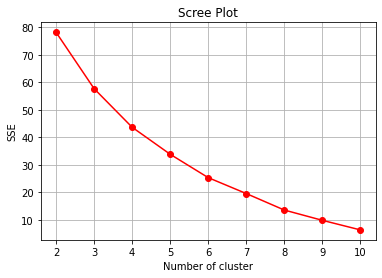

In [81]:
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init = 10, max_iter= 100).fit(kmeans_data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of squared distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'ro-')
plt.title("Scree Plot")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

In [113]:
clusters = 5
kmeans = KMeans(clusters,init="k-means++", n_init = 10, max_iter= 100)
kmeans.fit(kmeans_data) 

temp = cluster_data
temp["Cluster"] = kmeans.predict(kmeans_data)

goodness = silhouette_score(kmeans_data,temp["Cluster"])
print("Clusters =", clusters," Silhouette = ",goodness)


Clusters = 5  Silhouette =  0.6163742370395876


In [114]:
centers = dict()
centers['id'] = [1,2,3,4,5]
centers['name'] = ['cluster_1','cluster_2','cluster_3','cluster_4','cluster_5']
centers['cord_1']=kmeans.cluster_centers_[:,0]
centers['cord_2']=kmeans.cluster_centers_[:,1]
centers['cord_3']=kmeans.cluster_centers_[:,2]
centers['cord_4']=kmeans.cluster_centers_[:,3]
print(centers)

{'id': [1, 2, 3, 4, 5], 'name': ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5'], 'cord_1': array([0.875, 2.   , 2.   , 1.   , 1.   ]), 'cord_2': array([1.        , 1.74358974, 1.53333333, 1.        , 1.        ]), 'cord_3': array([0.75     , 1.8974359, 2.       , 2.       , 2.       ]), 'cord_4': array([0.3125    , 1.17948718, 0.        , 1.        , 0.        ])}


In [115]:
centers_df = pd.DataFrame(data=centers)
centers_df.head()

,id,name,cord_1,cord_2,cord_3,cord_4
0,1,cluster_1,0.875,1.000000,0.750000,0.312500
1,2,cluster_2,2.000,1.743590,1.897436,1.179487
2,3,cluster_3,2.000,1.533333,2.000000,0.000000
3,4,cluster_4,1.000,1.000000,2.000000,1.000000
4,5,cluster_5,1.000,1.000000,2.000000,0.000000


In [116]:
conn= sqlite3.connect("LaptopDB.db")
centers_df.to_sql('CLUSTERS', conn, if_exists='replace', index=False)

In [154]:
temp.price = temp.price.str[1:]
temp.price = temp.price.str.replace(',','')
temp.price = temp.price.astype(float)
temp.head()

,uuid,price,processor,memory,hard_drive,graphics,Cluster
0,ee58b3e8-1443-11eb-9321-0242ac1c0002,699.00,0,1,0,0,0
1,ee638a70-1443-11eb-9321-0242ac1c0002,1099.00,0,1,1,0,0
2,ee6d5fdc-1443-11eb-9321-0242ac1c0002,1148.99,1,1,1,0,0
3,ee785c5c-1443-11eb-9321-0242ac1c0002,1198.99,2,1,0,1,0
4,ee8291a4-1443-11eb-9321-0242ac1c0002,1248.99,1,1,2,0,4


In [155]:
cluster_1 = temp[temp.Cluster==0].drop(['Cluster'],axis=1)
cluster_1.to_sql('CLUSTER_1', conn, if_exists='replace', index=False)

In [156]:
cluster_2 = temp[temp.Cluster==1].drop(['Cluster'],axis=1)
cluster_2.to_sql('CLUSTER_2', conn, if_exists='replace', index=False)

In [157]:
cluster_3 = temp[temp.Cluster==2].drop(['Cluster'],axis=1)
cluster_3.to_sql('CLUSTER_3', conn, if_exists='replace', index=False)

In [158]:
cluster_4 = temp[temp.Cluster==3].drop(['Cluster'],axis=1)
cluster_4.to_sql('CLUSTER_4', conn, if_exists='replace', index=False)

In [159]:
cluster_5 = temp[temp.Cluster==4].drop(['Cluster'],axis=1)
cluster_5.to_sql('CLUSTER_5', conn, if_exists='replace', index=False)